# Intro to Kalman Filters and IMU

This Notebook contains implementation of Extended Kalman Filter to generate Quaternions from the multi-sensor data of Accelerometer, Gyroscope and Magentometer.

Things done in the Notebook so far:
* Clean Data to handle the newline skip condition
* Visualized 3D accelerometer and Magnetometer Data Temporaly
* Double Integrate Accelerometer Data to produce (BAD) Position Result
* Generate Quaternions from sensor data using [AHRS library][1]
* Convert the Quaternions to Rotation Matrix
* Get Clean Linear Acceleration from MATMUL on the Transposed Rotation Matrix and Orignal Acceleration
* Double Integrate the Clean Linear Accelerometer Data to produce (Better) Position Result


[1]:https://pypi.org/project/AHRS/

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from dataclasses import dataclass

import matplotlib.pyplot as plt # visualization
plt.rcParams.update({'font.size': 14})
import seaborn as sns # visualization

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

In [2]:
!pip install AHRS

     |████████████████████████████████| 196 kB 1.3 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
from tqdm import tqdm
from pathlib import Path
import json
import plotly.graph_objs as go
from PIL import Image
from datetime import datetime

from ahrs.filters import EKF
from ahrs.common.orientation import acc2q
from ahrs.utils import WMM
from scipy.spatial.transform import Rotation as R
from scipy import integrate

### Taking a Look at the text files

In [4]:
!head -n 30 "../input/indoor-location-navigation/train/5cd56c0ce2acfd2d33b6ab27/F2/5d09b234f03da60008286c44.txt"

#	startTime:1560915404366
#	SiteID:5cd56c0ce2acfd2d33b6ab27	SiteName:黄金钫	FloorId:5cd56c0ce2acfd2d33b6acc4	FloorName:F2
#	Brand:vivo	Model:vivo X20	AndroidName:8.1.0	APILevel:27	
#	type:1	name:BMI160 Accelerometer	version:2061700	vendor:BOSCH	resolution:0.0023956299	power:0.18	maximumRange:78.4532
#	type:4	name:BMI160 Gyroscope	version:2061700	vendor:BOSCH	resolution:0.0010681152	power:0.9	maximumRange:34.906586
#	type:2	name:AK09911 Magnetometer	version:1	vendor:AKM	resolution:0.1	power:0.24	maximumRange:4900.0
#	VersionName:v20190612-nightly	VersionCode:263	
1560915404368	TYPE_WAYPOINT	34.60297	31.68374
1560915404555	TYPE_ACCELEROMETER	0.03112793	-0.11730957	9.828201
1560915404555	TYPE_MAGNETIC_FIELD	-4.62	-39.899998	-60.059998
1560915404555	TYPE_GYROSCOPE	-0.13320923	0.088897705	0.085113525
1560915404555	TYPE_ROTATION_VECTOR	7.812922E-6	-0.0	-0.9984237
1560915404555	TYPE_MAGNETIC_FIELD_UNCALIBRATED	16.86	-40.499996	-115.2
1560915404555	TYPE_GYROSCOPE_UNCALIBRATED	-0.14753723	0.098541

In [5]:
train_folders = list(Path("../input/indoor-location-navigation/train/").glob("*"))
list(train_folders[0].glob("*"))

[PosixPath('../input/indoor-location-navigation/train/5cd56c0ce2acfd2d33b6ab27/B1'),
 PosixPath('../input/indoor-location-navigation/train/5cd56c0ce2acfd2d33b6ab27/F3'),
 PosixPath('../input/indoor-location-navigation/train/5cd56c0ce2acfd2d33b6ab27/F2')]

In [6]:
# copy from https://github.com/location-competition/indoor-location-competition-20/blob/master/io_f.py

@dataclass
class ReadData:
    acce: np.ndarray
    acce_uncali: np.ndarray
    gyro: np.ndarray
    gyro_uncali: np.ndarray
    magn: np.ndarray
    magn_uncali: np.ndarray
    ahrs: np.ndarray
    wifi: np.ndarray
    ibeacon: np.ndarray
    waypoint: np.ndarray

def append_util(data_type, data_dict, line_data):
    if data_type == "TYPE_WIFI":
        sys_ts = data_type
        ssid = line_data[1]
        bssid = line_data[2]
        rssi = line_data[3]
        lastseen_ts = line_data[5]
        data_dict[data_type].append([sys_ts, ssid, bssid, rssi, lastseen_ts])
    elif data_type == "TYPE_BEACON":
        ts = data_type
        uuid = line_data[1]
        major = line_data[2]
        minor = line_data[3]
        rssi = line_data[5]
        data_dict[data_type].append([ts, '_'.join([uuid, major, minor]), rssi])
    else:
        data_dict[data_type].append([int(line_data[0]), *[float(item) for item in line_data[1:]]])
        
def read_data_file(data_filename):
    acce = []
    acce_uncali = []
    gyro = []
    gyro_uncali = []
    magn = []
    magn_uncali = []
    ahrs = []
    wifi = []
    ibeacon = []
    waypoint = []
    
    data_dict = {
        "TYPE_WAYPOINT": waypoint,
        "TYPE_ACCELEROMETER": acce,
        "TYPE_ACCELEROMETER_UNCALIBRATED": acce_uncali,
        "TYPE_GYROSCOPE": gyro,
        "TYPE_GYROSCOPE_UNCALIBRATED": gyro_uncali,
        "TYPE_MAGNETIC_FIELD": magn,
        "TYPE_MAGNETIC_FIELD_UNCALIBRATED": magn_uncali,
        "TYPE_ROTATION_VECTOR": ahrs,
        "TYPE_WIFI": wifi,
        "TYPE_BEACON":ibeacon
    }

    with open(data_filename, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    for line_data in lines:
        line_data = line_data.strip()
        if not line_data or line_data[0] == '#':
            continue
            
        if line_data.count("TYPE_") == 1:
            line_data = line_data.split('\t')
            append_util(line_data.pop(1), data_dict, line_data)
            
        elif line_data.count("TYPE_") == 2:
            line_data_split = line_data.split('\t')
            type_index = []
            total = 0
            for item in line_data_split:
                if "TYPE_" in item:
                    type_index.append(total)
                total+=len(item)+1
                
            line_data_split = line_data[:type_index[1]-14].split('\t')
            append_util(line_data_split.pop(1), data_dict, line_data_split)

            line_data_split = line_data[type_index[1]-14:].split('\t')
            append_util(line_data_split.pop(1), data_dict, line_data_split)
    
    acce = np.array(acce)
    acce_uncali = np.array(acce_uncali)
    gyro = np.array(gyro)
    gyro_uncali = np.array(gyro_uncali)
    magn = np.array(magn)
    magn_uncali = np.array(magn_uncali)
    ahrs = np.array(ahrs)
    wifi = np.array(wifi)
    ibeacon = np.array(ibeacon)
    waypoint = np.array(waypoint)
    
    return ReadData(acce, acce_uncali, gyro, gyro_uncali, magn, magn_uncali, ahrs, wifi, ibeacon, waypoint)

In [7]:
def visualize_trajectory(trajectory, floor_plan_filename, width_meter, height_meter, title=None, mode='lines + markers + text', show=False):
    """
    Copied from from https://github.com/location-competition/indoor-location-competition-20/blob/master/visualize_f.py

    """
    fig = go.Figure()

    # add trajectory
    size_list = [6] * trajectory.shape[0]
    size_list[0] = 10
    size_list[-1] = 10

    color_list = ['rgba(4, 174, 4, 0.5)'] * trajectory.shape[0]
    color_list[0] = 'rgba(12, 5, 235, 1)'
    color_list[-1] = 'rgba(235, 5, 5, 1)'

    position_count = {}
    text_list = []
    for i in range(trajectory.shape[0]):
        if str(trajectory[i]) in position_count:
            position_count[str(trajectory[i])] += 1
        else:
            position_count[str(trajectory[i])] = 0
        text_list.append('        ' * position_count[str(trajectory[i])] + f'{i}')
    text_list[0] = 'Start 0'
    text_list[-1] = f'End {trajectory.shape[0] - 1}'

    fig.add_trace(
        go.Scattergl(
            x=trajectory[:, 0],
            y=trajectory[:, 1],
            mode=mode,
            marker=dict(size=size_list, color=color_list),
            line=dict(shape='linear', color='lightgrey', width=3, dash='dash'),
            text=text_list,
            textposition="top center",
            name='trajectory',
        ))

    # add floor plan
    floor_plan = Image.open(floor_plan_filename)
    fig.update_layout(images=[
        go.layout.Image(
            source=floor_plan,
            xref="x",
            yref="y",
            x=0,
            y=height_meter,
            sizex=width_meter,
            sizey=height_meter,
            sizing="contain",
            opacity=1,
            layer="below",
        )
    ])

    # configure
    fig.update_xaxes(autorange=False, range=[0, width_meter])
    fig.update_yaxes(autorange=False, range=[0, height_meter], scaleanchor="x", scaleratio=1)
    fig.update_layout(
        title=go.layout.Title(
            text=title or "No title.",
            xref="paper",
            x=0,
        ),
        autosize=True,
        width=800,
        height=  800 * height_meter / width_meter,
        template="plotly_white",
    )

    if show:
        fig.show()

    return fig

def visualize_train_trajectory(txt_path):
    """
    Edited from 
    https://www.kaggle.com/hrshtt/intro-to-indoor-location-navigation/
    who Edited from 
    https://www.kaggle.com/ihelon/indoor-location-exploratory-data-analysis
    """
#     _id, floor = path.split("/")[:2]
    if not isinstance(txt_path, Path):
        path = Path(txt_path)
    
    _id, floor, filename = txt_path.parts[-3:]

    
    train_floor_data = read_data_file(txt_path)
    with open(f"../input/indoor-location-navigation/metadata/{_id}/{floor}/floor_info.json") as f:
        train_floor_info = json.load(f)

    return visualize_trajectory(
        train_floor_data.waypoint[:, 1:3], 
        f"../input/indoor-location-navigation/metadata/{_id}/{floor}/floor_image.png",
        train_floor_info["map_info"]["width"], 
        train_floor_info["map_info"]["height"],
        f"Visualization of {_id}/{floor}/{filename}"
    )


In [8]:
sample_txt_file_path = list(list(train_folders[0].glob("*"))[2].glob("*"))[5]
# sample_txt_file_path = Path("../input/indoor-location-navigation/train/5a0546857ecc773753327266/F2/5dccf516c04f060006e6e3c9.txt")


In [9]:
sample_data = read_data_file(sample_txt_file_path)
print('acce shape:', sample_data.acce.shape)
print('acce_uncali shape:', sample_data.acce_uncali.shape)
print('gyro shape:', sample_data.gyro.shape)
print('gyro_uncali shape:', sample_data.gyro_uncali.shape)
print('magn shape:', sample_data.magn.shape)
print('magn_uncali shape:',sample_data.magn_uncali.shape)
print('ahrs shape:', sample_data.ahrs.shape)
print('wifi shape:', sample_data.wifi.shape)
print('ibeacon shape:', sample_data.ibeacon.shape)
print('waypoint shape:', sample_data.waypoint.shape)


acce shape: (2712, 4)
acce_uncali shape: (2712, 4)
gyro shape: (2712, 4)
gyro_uncali shape: (2712, 4)
magn shape: (2712, 4)
magn_uncali shape: (2712, 4)
ahrs shape: (2712, 4)
wifi shape: (5175, 5)
ibeacon shape: (0,)
waypoint shape: (4, 3)


In [10]:
# temp = np.concatenate([sample_data.acce, 
#                        sample_data.acce_uncali[:, 1:],
#                        sample_data.gyro[:, 1:],
#                        sample_data.gyro_uncali[:, 1:],
#                        sample_data.magn[:, 1:],
#                        sample_data.magn_uncali[:, 1:],
#                        sample_data.ahrs[:, 1:],
#                       ], axis=1)

# imu_df = pd.DataFrame(temp)

# del temp

# imu_df.columns = ['timestamp', 'acce_x','acce_y', 'acce_z','acce_uncali_x','acce_uncali_y', 'acce_uncali_z',
#               'gyro_x','gyro_y', 'gyro_z','gyro_uncali_x','gyro_uncali_y', 'gyro_uncali_z',
#               'magn_x','magn_y', 'magn_z','magn_uncali_x','magn_uncali_y', 'magn_uncali_z',
#               'ahrs_x','ahrs_y', 'ahrs_z']

# display(imu_df.head(8).style.set_caption('IMU Data'))

In [11]:
waypoint_df = pd.DataFrame(sample_data.waypoint)
waypoint_df.columns = ['timestamp', 'waypoint_x','waypoint_y']
display(waypoint_df.style.set_caption('Waypoint'))

,timestamp,waypoint_x,waypoint_y
0,1560915404368.000000,34.602970,31.683740
1,1560915410212.000000,34.466713,27.811998
2,1560915437527.000000,47.287230,36.145344
3,1560915456401.000000,34.602970,31.683740


### Trajectory of the Waypoints


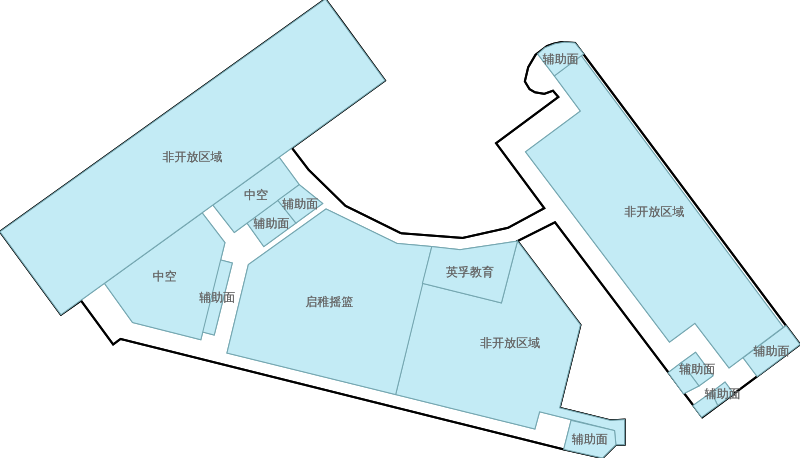

In [12]:
visualize_train_trajectory(sample_txt_file_path)


In [13]:
from mpl_toolkits.mplot3d import Axes3D
def plot_3d_graph(x,y,z, c=None):
    sns.set(style = "darkgrid")

    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, projection = '3d')

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

    ax.scatter(x, y, z, c=c)
    ax.set_title("acce")
    plt.show()

### Plotting cumulative sum of acceleration vector moving in time.

This should give us a general idea of which direction the change in motion is happening.

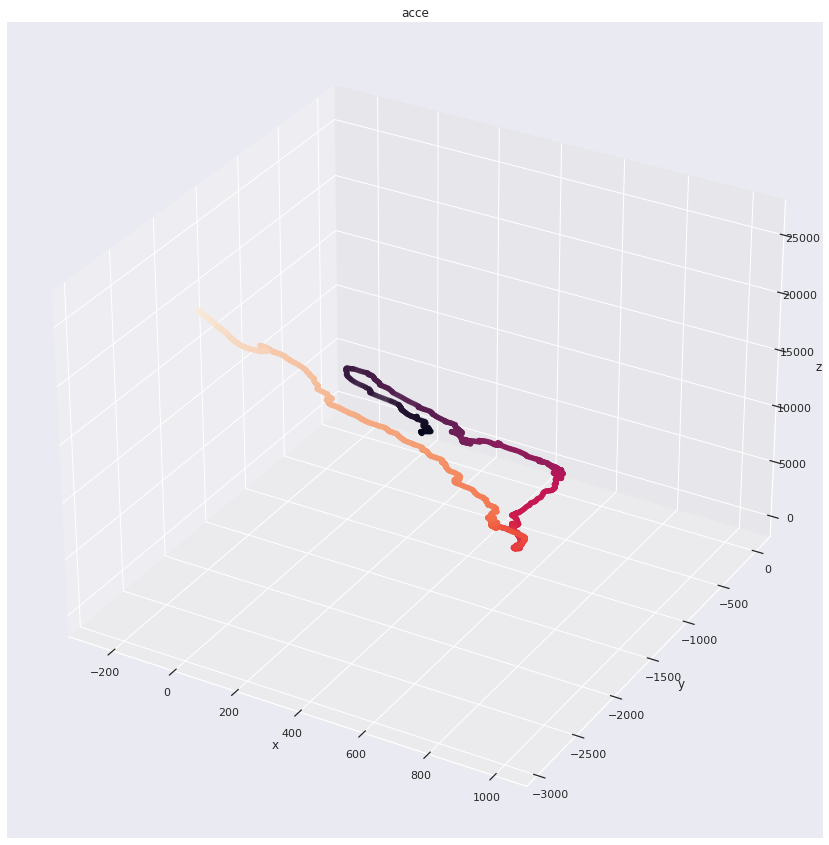

In [14]:
plot_3d_graph(
    np.cumsum(sample_data.acce[:,1]),
    np.cumsum(sample_data.acce[:,2]),
    np.cumsum(sample_data.acce[:,3]),
    sample_data.acce[:,0]    
)


### Double Integrating the Orignal Acceleration to Generate "BAD" Position Vectors (Noisy Data Makes the Integration Drift)

In [15]:
time_ = sample_data.acce[:,0]

vel_x = integrate.cumtrapz(sample_data.acce[:,1], time_, initial=0)
vel_y = integrate.cumtrapz(sample_data.acce[:,2], time_, initial=0)
vel_z = integrate.cumtrapz(sample_data.acce[:,3], time_, initial=0)

pos_x = integrate.cumtrapz(vel_x, time_, initial=0)
pos_y = integrate.cumtrapz(vel_y, time_, initial=0)
pos_z = integrate.cumtrapz(vel_z, time_, initial=0)

### BAD Position Plot

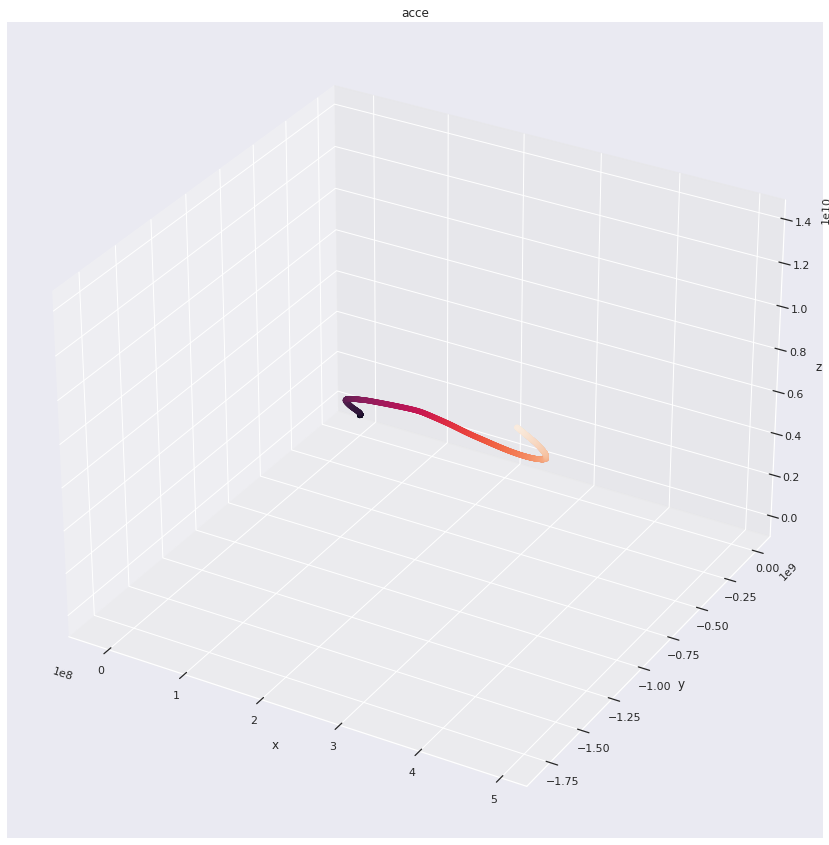

In [16]:
plot_3d_graph(
    pos_x,
    pos_y,
    pos_z,
    sample_data.acce[:,0]    
)


### Plotting cumulative sum of magnetometer vector moving in time.

I dont know what to do from magnetometer readings but it still looks like there is a strong directional output to the sensor

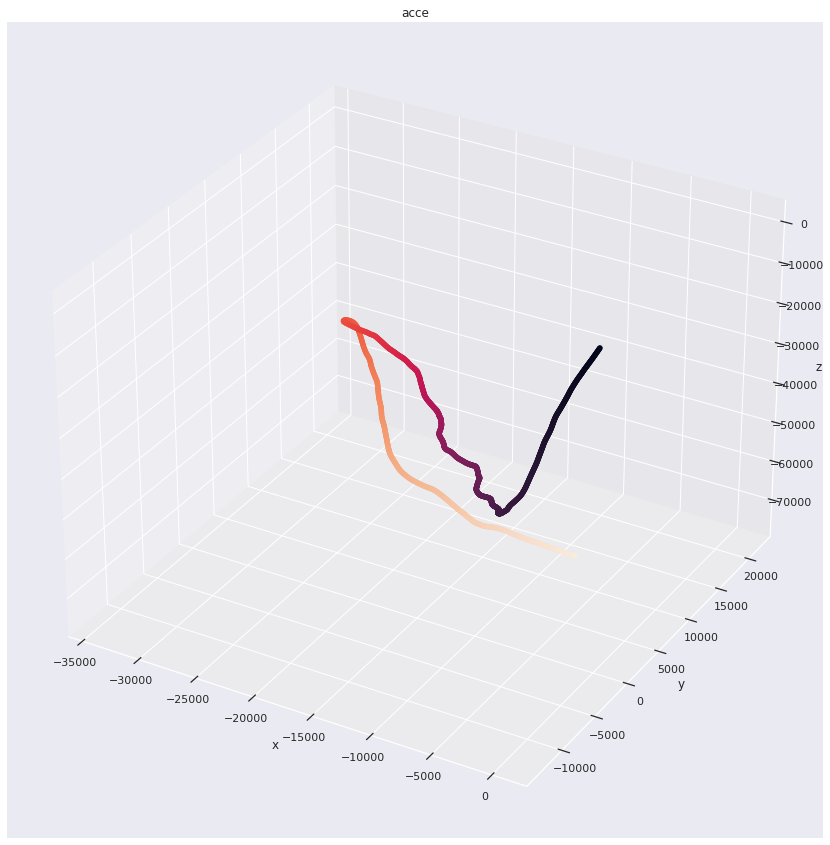

In [17]:
plot_3d_graph(
    np.cumsum(sample_data.magn[:,1]),
    np.cumsum(sample_data.magn[:,2]),
    np.cumsum(sample_data.magn[:,3]),
    sample_data.magn[:,0]    
)

### Using EKF from ahrs library, 
Note: the magnetometer readings are supposed to be added with a correction value to handle the True North vs Magnetic North seperation, I have not implemented this yet.


In [18]:
ekf_estimator = EKF(gyr=sample_data.gyro[:,1:4], acc=sample_data.acce[:,1:4], mag=sample_data.magn[:,1:4], frequency=50.0)
# Initializing the class with the sensor data generates our Quaternion in the Q Variable

Q = ekf_estimator.Q
n_samples = sample_data.acce.shape[0]
new_acce = np.zeros((n_samples, 3))
# Initializing Array to hold the Linear acceleration Vector

for t in range(n_samples):
    r = R.from_quat(Q[t])
    # Getting a Rotation Matrix from the Quaternions
    new_acce[t] = np.matmul(r.as_matrix().T,sample_data.acce[t][1:4])
    # matmul Rotation Matrix Transpose to orignal Acceleration to produce the clean linear acceleration


### Double Integrating the Clean Linear Acceleration to Generate "Better" Position Vectors

In [19]:
vel_x = integrate.cumtrapz(new_acce[:,0], time_, initial=0)
vel_y = integrate.cumtrapz(new_acce[:,1], time_, initial=0)
vel_z = integrate.cumtrapz(new_acce[:,2], time_, initial=0)

pos_x = integrate.cumtrapz(vel_x, time_, initial=0)
pos_y = integrate.cumtrapz(vel_y, time_, initial=0)
pos_z = integrate.cumtrapz(vel_z, time_, initial=0)

### Better Position Plot

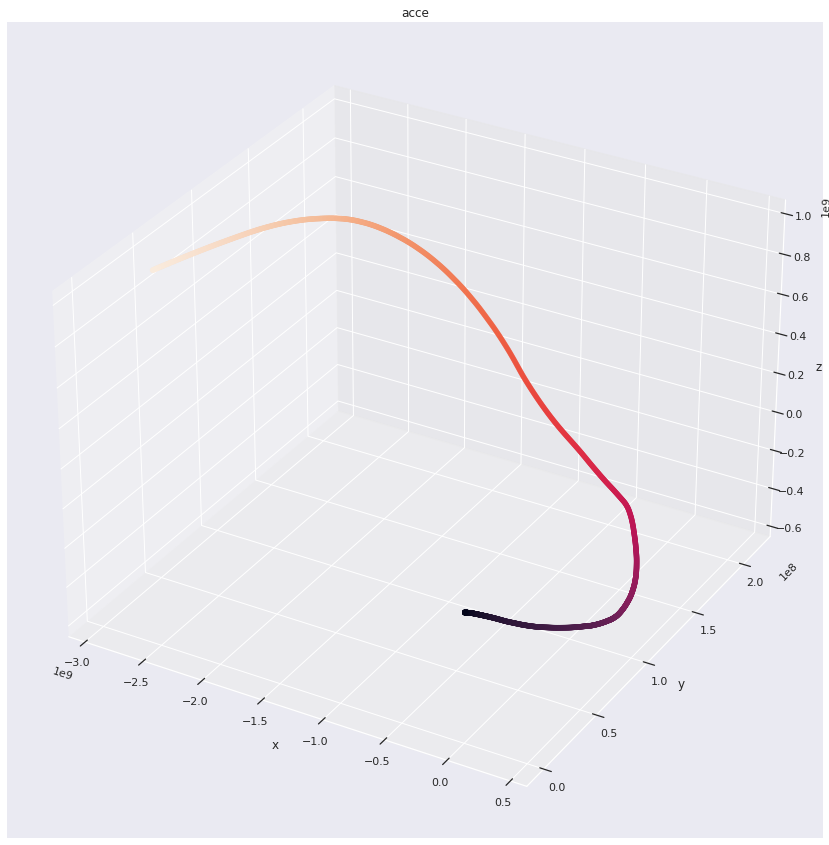

In [20]:
plot_3d_graph(
    pos_y,
    pos_x,
    pos_z,
    sample_data.magn[:,0]    
)


I read up somewhere that the axis may get switched up during the calculations, so to confirm our result, am confirming to see which axis has the least effect on the plot (It should be the Z axis as there is not much movement in that space.)

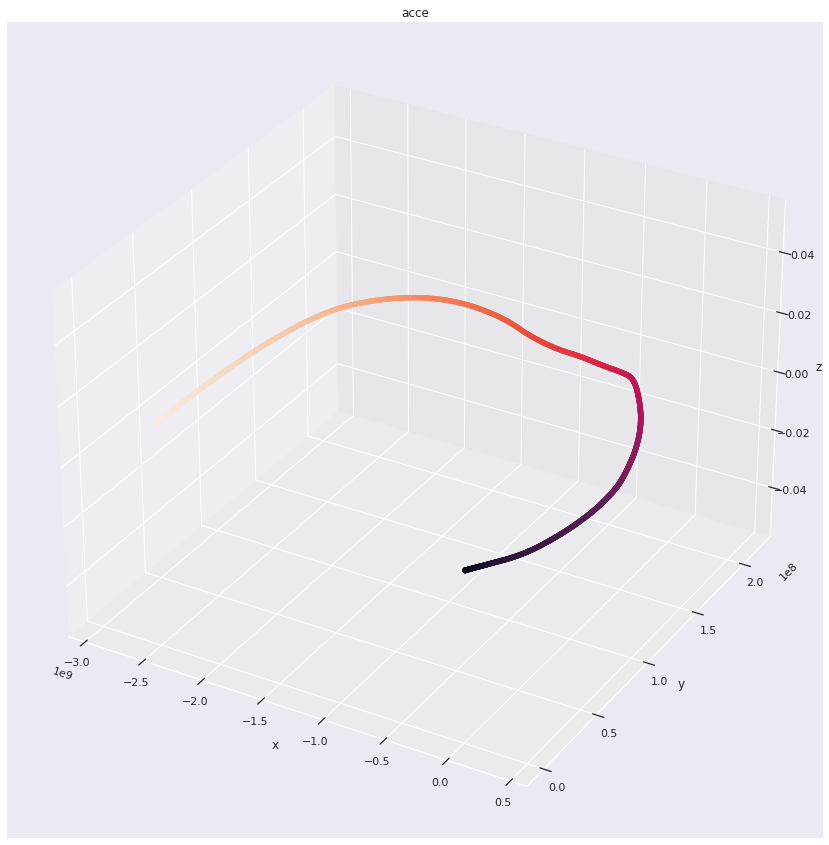

In [21]:
plot_3d_graph(
    pos_y,
    pos_x,
    np.zeros_like(pos_z),
    sample_data.magn[:,0]    
)


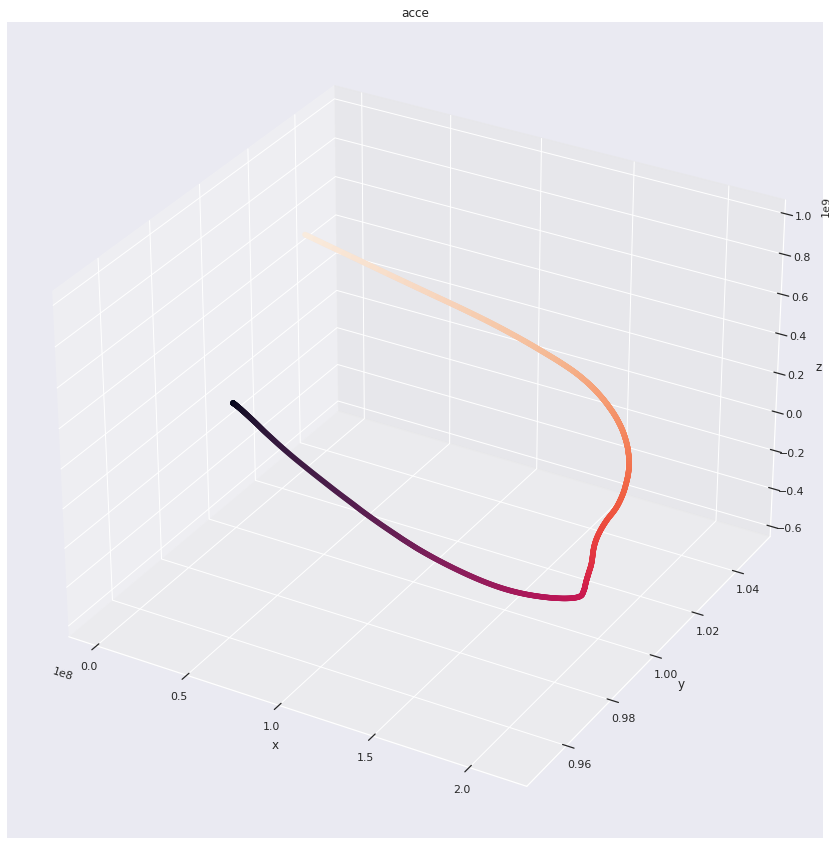

In [22]:
plot_3d_graph(
    pos_x,
    np.ones_like(pos_y),
    pos_z,
    sample_data.magn[:,0]    
)


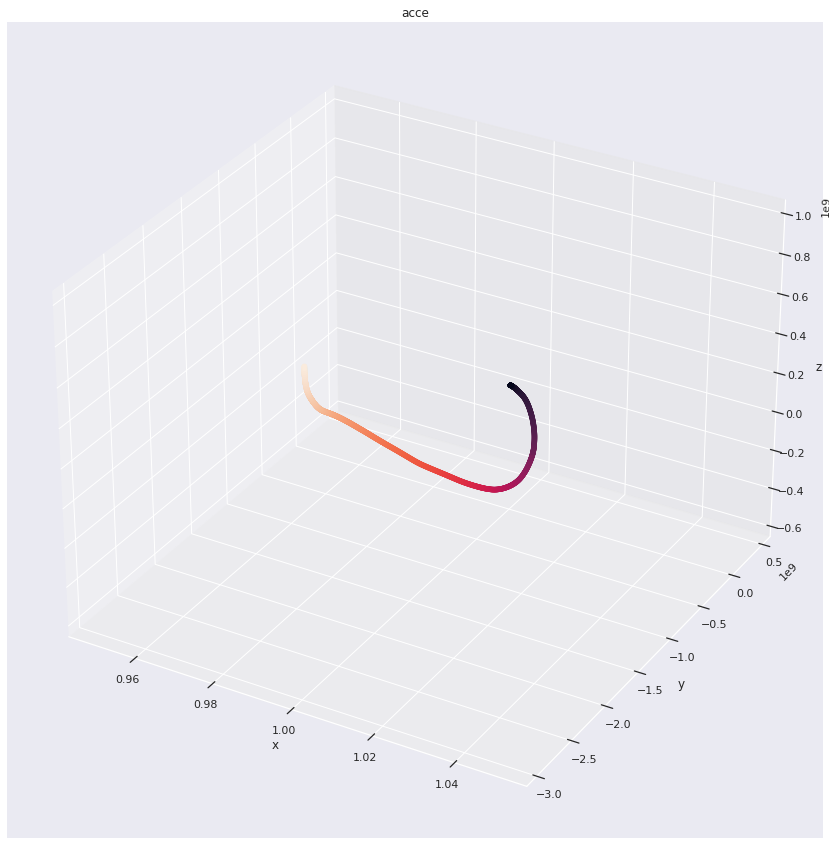

In [23]:
plot_3d_graph(
    np.ones_like(pos_x),
    pos_y,
    pos_z,
    sample_data.magn[:,0]    
)
